<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/tonic%2Bpitch_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# #importing nessecary libraries
# import librosa
# import librosa.display
# import numpy as np
# import math
# import matplotlib.pyplot as plt
# from scipy.fftpack import *
# from scipy.signal import kaiserord, lfilter, firwin, freqz, spectrogram
# plt.rcParams['figure.figsize'] = [10, 5]
# freq_cqt = librosa.cqt_frequencies(90, fmin=32)
# from swipe import *
                                   

In [0]:
# importing nessecary libraries
import librosa
import librosa.display
from swipe import *

plt.rcParams['figure.figsize'] = [20,5]
# cqt bin frequencies
freq_cqt = librosa.cqt_frequencies(90, fmin=32)

ratios = {'Sa':1,'Ri1':16/15,'Ri2/Ga1':9/8,'Ga2/Ri3':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa':3/2,'Da1':8/5,
          'Da2/Ni1':5/3,'Ni2/Da3':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)

In [0]:
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    
    # bandpass filter with cutoff [110,500] to remove harmonics
    """
    nyq_rate = self.sr1 / 2.0
    width = 5.0/nyq_rate
    N, beta = kaiserord(60.0, width)
    taps = firwin(N, [i/nyq_rate for i in [110.0, 500.0]], window=('kaiser', beta),pass_zero=False)
    self.x = lfilter(taps, 1.0, self.x)
    """
    self.pitch_contour()
    self.constant_pitch()

  #c omputer the spectrum of the audio file
  # uses cqt 
  def spectrogram(self,plot = False):
    cqt = librosa.cqt(self.x,sr=self.sr1)
    self.logC = librosa.amplitude_to_db(np.abs(cqt),ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'cqt_hz')
  """
  def spectrogram(self,plot = False):
    stft = librosa.stft(self.x)
    S, phase = librosa.magphase(stft)
    self.logC = librosa.amplitude_to_db(S,ref = np.max)
    if plot:
      librosa.display.specshow(self.logC, sr=self.sr1, x_axis='time',y_axis = 'log')
  """

  # lowpass filter for the frequencies
  def low_pass_digital(self,S, dt = 70, ts = 50): # parameters have to be verified
    low = []
    alpha = dt/(int(dt)+ts)
    low.append((1-alpha)*S[0])
    for i in range(1,len(S)):
      g = (1-alpha)*S[i] + alpha*low[i-1]
      low.append(g)
    return low

  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    """
    pitch = []
    i,j = self.logC.shape
    step = np.ones(j)
    
    # checking the maximum power component along the coloumn of the spectogram 
    # and storing the index of the same which is then mapped into its corresponding frequencies
    for k in range(0,j):
      temp = np.where(self.logC[:,k]==np.amax(self.logC[:,k]))
      pitch.append(temp[0][0])
      # removing spectral cavity
      if np.amax(self.logC[:,k]) < -15:  
        step[k] = np.nan
   
    pitch = [ freq_cqt[i] for i in pitch]
    pitch = self.low_pass_digital(pitch)
    self.pitch = [round(a*b) for a,b in zip(pitch,step)]
    """
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
  #mean value of the cpn is pending!!
  # one semitone per, second???
  def constant_pitch(self):
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    """
    self.normalised_pitch=[]
    for i in self.pitch:
      self.normalised_pitch.append((12*np.log2(i/192)))
    
    # calculating the 1st order difference
    self.diff_n = np.diff(self.normalised_pitch)
    """
    time_axis_80 = []
    pitch_80 = []
    for i in range(0,len(self.time_axis),8):
      pitch_80.append(self.pitch[i])
      time_axis_80.append(self.time_axis[i])
    self.diff_n = np.diff(pitch_80)
    k=[]
    for i in range(len(self.diff_n)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(self.diff_n[i]<4 and self.diff_n[i]>-4):
        k.append((pitch_80[i],time_axis_80[i]))
    k = np.array(k)
    self.cpn,self.constant_pitch_time = k.T
    #self.constant_pitch_notes = [(i,j) for i,j in all_normalized_notes.items() if j in self.cpn]
  

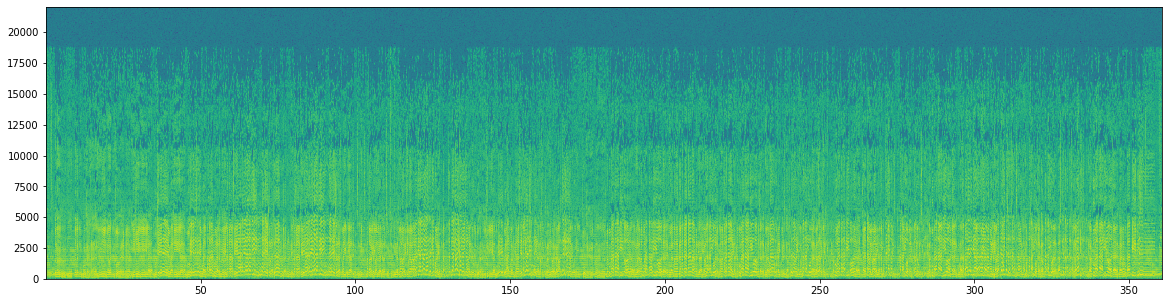

In [9]:
rkm_a = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')

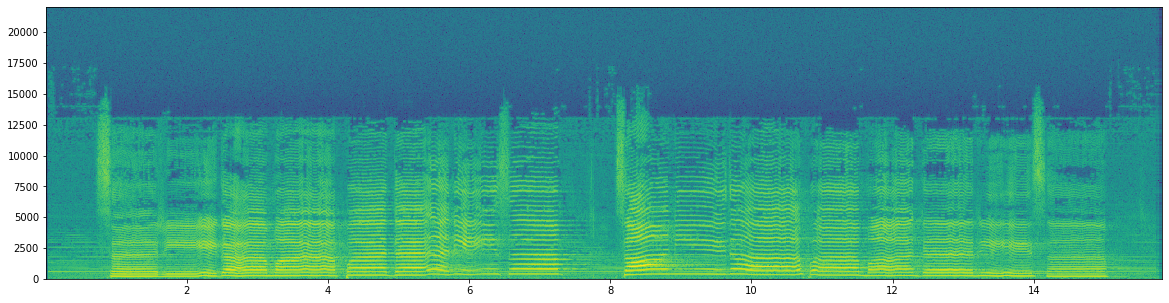

In [10]:
test_surabhi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')

In [0]:
 test_surabhi.cpn.sort()
 print(test_surabhi.cpn)


[193.0826791  193.25702171 193.43152175 193.95596781 193.95596781
 194.13109895 194.65744176 194.83320629 195.3614527  195.3614527
 196.06800982 196.06800982 196.24504802 196.42224607 196.59960413
 196.95480081 197.84560264 198.5611441  201.08598022 219.88036053
 222.47540201 239.34880172 241.73686473 242.39227986 242.83021021
 245.25300839 246.1400066  246.1400066  246.58470797 246.80735986
 247.03021279 247.25326694 247.25326694 247.69997964 248.82029554
 249.04496604 259.13392782 292.71144714 292.97574883 293.77008667
 294.03534425 294.56657817 294.83255494 295.36522919 295.36522919
 296.43346656 296.43346656 296.70112903 296.96903317 297.7741979
 298.04307097 301.56059355 331.83561843 332.73531607 333.63745303
 380.28560602 386.51404343 387.2123587  389.31488352 389.66641259
 392.49009604 392.84449215 392.84449215 393.55424465 394.26527946
 394.26527946 394.26527946 394.62127845 395.33424107 395.69120528
 396.0484918  396.0484918  396.40610094 396.76403297 397.1222882
 397.48086691

In [0]:
def tonic_check(testcpn):
  tonic=-1
  tonic_candidates=[]
  testcpn.cpn.sort()
 
  # print(testcpn.cpn)
  sortedcpn= testcpn.cpn[::-1]
  # print(sortedcpn)
  sortedcpn_floored=[]
  for i in range(len(sortedcpn)):
    sortedcpn_floored.append(math.floor(sortedcpn[i]))
  setcpn=list((sortedcpn_floored))
  ratio=12
  min_difference=2
  pos=-1
  for i in range(len(setcpn)):
    for j in range(i,len(setcpn)):
      ratio=(setcpn[i]/setcpn[j])
      difference=abs(ratio-1.5)
      # print(difference)
      if(difference<min_difference and ratio>1.49 and ratio <1.51):
             pos=j
             min_difference=difference
             tonic =sortedcpn[j]
             tonic_candidates.append(sortedcpn[j])
    
  
  print(tonic_candidates)



      
  # print(sortedcpn)
  # for i in ratios:
    # difference.append(absolute(i-1.5))


  # tonic_position= .index(min(a)

  # print(difference.index(min(difference)))
  # print(tonic)


# tonic_check(rkm_a)
# tonic_check(rkm1)
# tonic_check(rkm2)
tonic_check(test_surabhi)
tonic_check(rkm1)
tonic_check(rkm2)



[259.13392781611657, 222.47540200933247]
[293.77008666740517, 252.21173730683776, 252.21173730683776]
[307.608154766341, 298.8511477148218, 297.7741979048887, 292.18355883613816]


In [0]:
plt.plot(test.pitch)

In [0]:
test.pitch

In [28]:
#checking the ratio of different notes to shadja

def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num  
# def add_to_tonic_candidates(uniquepitchfloor,n,)
def tonic(testo):
  store_tonic_pa=list()
  store_tonic_ri2=list()
  store_tonic_ma1=list()
  store_tonic_ga3=list()
  store_tonic_ni3=list()
  floored=[]
  toniclist=[]
  uniquepitch=set(testo.cpn)
  uniquepitchfloor=[]
  for i in uniquepitch:
    i=math.floor(i)
    uniquepitchfloor.append(i)
  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.49) and ((i/j) <1.51) and j<220):
            # print(j)
            store_tonic_pa.append(j)
  
  pa_to_sa=most_frequent(store_tonic_pa)
  toniclist.append(pa_to_sa)

  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.1) and ((i/j) <1.14) and j<220):
            # print(j)
            store_tonic_ri2.append(j)
  
  ri2_to_sa=most_frequent(store_tonic_ri2)
  toniclist.append(ri2_to_sa)

  if(abs(toniclist[1]-toniclist[0])< 5):
    print(toniclist[0])
    return toniclist[0]


  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.29) and ((i/j) <1.35) and j<220):
            # print(j)
            store_tonic_ma1.append(j)
  
  ma1_to_sa=most_frequent(store_tonic_ma1)
  toniclist.append(ma1_to_sa)
  
  if((abs(toniclist[2]-toniclist[0])< 5) or (abs(toniclist[2]-toniclist[1])< 5)):
    print(toniclist[2])
    return toniclist[2]


  
  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.2) and ((i/j) <1.27) and j<220):
            # print(j)
            store_tonic_ga3.append(j)
  
  ga3_to_sa=most_frequent(store_tonic_ga3)
  toniclist.append(ga3_to_sa)


  if((abs(toniclist[3]-toniclist[0])< 5) or (abs(toniclist[3]-toniclist[1])< 5) or (abs(toniclist[3]-toniclist[2])< 5)):
    print(toniclist[3])
    return toniclist[3]


  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.85) and ((i/j) <1.9) and j<220):
            # print(j)
            store_tonic_ni3.append(j)
  
  ni3_to_sa=most_frequent(store_tonic_ni3)
  toniclist.append(ni3_to_sa)
  
  if((abs(toniclist[4]-toniclist[0])< 5) or (abs(toniclist[4]-toniclist[1])< 5) or (abs(toniclist[4]-toniclist[2])< 5) or (abs(toniclist[4]-toniclist[3])< 5)):
    print(toniclist[4])
    return toniclist[4]
  # print("tonic not found sigh")
  print(toniclist[0])
  return toniclist[0] #lets just assume Pa was there


#works 

tonic(test_surabhi)
tonic(rkm1)
tonic(rkm2)
tonic(rkm_a)



193
149
148
149


149

In [0]:
# Now, to test another audio clip
test3=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3',duration = 40)



In [0]:
plt.plot(test3.pitch)

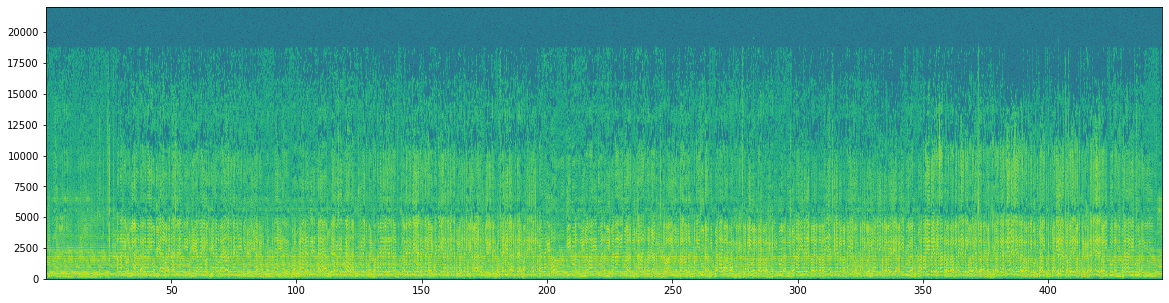

In [12]:
rkm1=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223593__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-mohanam-raaga.mp3')
rkm2=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223588__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-kalyani-raaga.mp3')

In [0]:
tonic(rkm1)



In [0]:
tonic(rkm2)

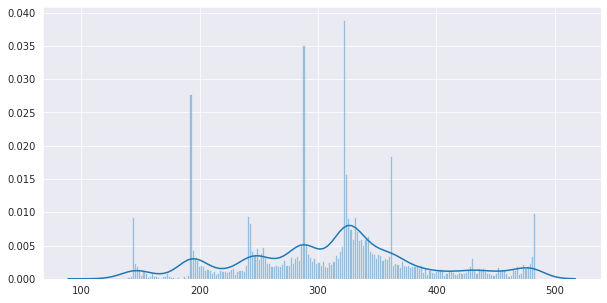

In [0]:
#checking out smooth histograms
import seaborn as sns

test2=Audio('/content/drive/My Drive/AA/Music dataset/Raga_Surabhi_3.wav')
free= test.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free,bins=200)

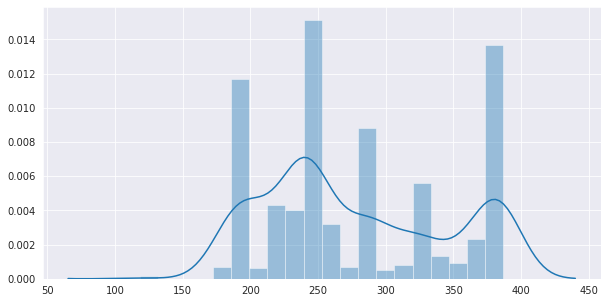

In [0]:
free2= test2.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free2,bins=20)

https://pages.mtu.edu/~suits/notefreqs.html

In [0]:
most_frequent([i for i in rkm2.pitch if i>320 and i<325])

321.1790100012322